# Evaluación de Modelos #

El aprendizaje automático implica la __construcción de modelos matemáticos__ para ayudar a comprender los datos.

En este notebook veremos cómo implementar los pasos necesarios para una correcta evaluación de modelos.

## Challenge ##
Los modelos tienen que generalizar. Cuando los/as Data Scientists entrenamos uno, lo hacemos en base a datos que ya tenemos y buscamos que predigan otros con los que no contamos. Por eso es importante que los que tenemos -__la muestra__- sean representativos de todos los datos -__la población__-.
1.	 Para pensar: ahora que sabemos que podemos evaluar los modelos con los datos de entrenamiento y con los de testeo, ¿qué desempeño va a tener en cada parte del Dataset (train y test) un modelo con overfitting (sobreajuste)? ¿y uno con underfitting (subajuste)?
Con __Overfitting__ sobreajuste, estamos hablando de un modelo más complejo, el cual  no logra un nivel de abstracción suficiente como para generar algún tipo de aprendizaje, es decir, hay una gran distancia entre el desempeño en el conjunto de entrenamiento y el conjunto de testeo.
Con __Underfiting__  los modelos simples tienden a desempeñarse peor de lo que podrían, un modelo pone una línea divisoria demasiado general, que va a tener muy bajo desempeño a la hora de hacer una predicción, tanto con los datos del muestreo como de la población.
2.	 Para pensar: cuanto más profundo sea un árbol ¿el modelo va a tender al Overfitting o al Underfitting? ¿y con la cantidad de vecinos en kNN? En ambos casos __Overfitting__.

## 1. Train-Test Split y Optimización de Hiperparámetros ##
### 1.1 Train-Test Split ###
1. Carga del dataset y separa en X e y como venimos haciendo.

In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris

In [21]:
iris = load_iris()
data = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [22]:
X = data[["sepal width (cm)", "sepal length (cm)"]]
y = data[["target"]]

Luego, como aprendimos, vamos a separar el dataset en conjuntos de entrenamiento X_train, y_train y de testeo X_test,y_test usando la función train_test_split de Scikit-Learn. Esto lo hacemos __para separar parte de los datos X_test,y_test con los cuales no vamos a entrenar el modelo__, sino que vamos a usarlos únicamente para evaluar su desempeño.

2. Separa X e y, tomando en las variables X_train, y_train un 70% para entrenamiento y en las variables X_test,y_test un 30% para evaluación. Recuerda fijar el random_state.

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3, random_state = 42)
X_train.shape, y_train.shape
X_test.shape, y_test.shape

((45, 2), (45, 1))

3. Crea un modelo de vecino más cercanos y entrénalo sobre el conjunto de Train.

In [25]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier()

In [26]:
clf_knn.fit(X_train, np.ravel(y_train))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

4. Predice las etiquetas sobre el conjunto de Train y sobre el conjunto de Test.

In [27]:
y_train_pred = clf_knn.predict(X_train)

In [28]:
y_test_pred = clf_knn.predict(X_test)

5. Evalúa el desempeño del modelo usando la función accuracy_score y la matriz de confusión sobre ambos conjuntos (Train y Test).

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train,y_train_pred)

0.8666666666666667

In [30]:
accuracy_score(y_test, y_test_pred)

0.8

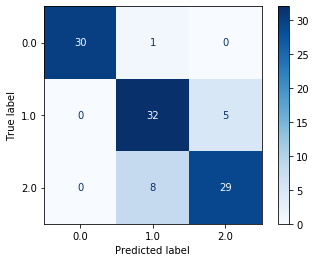

In [31]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_knn, X_train, y_train, cmap=plt.cm.Blues, values_format = '.0f')

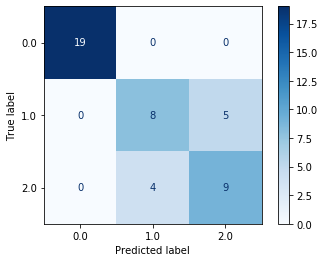

In [32]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_knn, X_test, y_test, cmap=plt.cm.Blues, values_format = '.0f')

Para Pensar:

* ¿Qué ocurre con el desempeño con número de vecinos igual a 1 y un número de vecinos grande (del orden del tamaño del dataset?
* ¿Cuál será el número óptimo de vecinos para este modelo?¿Cómo podrías obtenerlo?

Si k  = 1, entonces el objeto simplemente se asigna a la clase de ese vecino más cercano. Éste enfoque contiene una falla fundamental: entrena y evalúa el modelo con los mismos datos.  
Deberíamos elegir k lo suficientemente grande como para minimizar el ruido en los datos y lo suficientemente pequeño para que no se incluyan las muestras de las otras clases.

### 1.2 Encontrando el mejor hiperparámetro

Durante el entrenamiento, el modelo ajusta ciertas característica intrínsecas que llamamos parámetros. Por ejemplo, un árbol de decisión debe decidir automáticamente con qué umbrales comparar ciertos atributos en cada nodo. Pero los hiperparámetros son características que debemos definir nosotros; por ejemplo, la profundidad del árbol o el número de vecinos. Optimización de hiperparámetros se lleva un tiempo considerable en un flujo de ML, y si bien hay técnicas más o menos automáticas para hacerlo, al final siempre tiene algo artesanal. Además, está fuertemente ligado a la evaluación de nuestro modelo: siempre optimizamos hiperparámetros dada cierta métrica. Esta métrica se define en función del problema, nuestras necesidades y posibilidades.

 En esta sección vamos a empezar haciendo la optimización más sencilla posible, un sólo hiperparámetro. En este caso, una buena opción es probar con muchos valores del hiperparámetro, y graficar su desempeño en función de estos valores. De esta forma, variamos la complejidad del modelo y observámos como impacta en su desempeño. Estas curvas se llaman curvas de validación, y se pueden hacer automáticamente desde Scikit-Learn, pero primero las vamos a hacer a mano para entender bien su funcionamiento.

Vamos a ver esto en el caso de un modelo de vecinos más cercanos. Para ello, debemos evaluar la exactitud y del modelo en el set de train y test para distintos valores del parámetro n_neighbors. Vamos entonces a repetir el esquema de: definir, entrenar y predecir en un loop for que recorre una lista con distintos valores de vecinos.

__Ejercicio:__ Trabaja en el siguiente bloque de codigo, de manera de completar con valores las listas lista_accuracy_train y lista_accuracy_test.

In [33]:
# Definimos las listas vacias para los valores de accuracy deseados
lista_accuracy_train = []
lista_accuracy_test = []

# Definimos la lista de valores de k que vamos a explorar
k_vecinos = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,50]

# Generamos un loop sobre los distintos valores de k 
for k in k_vecinos:
    
    # Vamos a repetir el siguiente bloque de código
    
    # Definir el modelo con el valor de vecinos deseado
    clf = KNeighborsClassifier(n_neighbors= k)
    
    # Entrenar el modelo
    clf.fit(X_train, np.ravel(y_train))
    
    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    # Agregar la información a las listas
    lista_accuracy_train.append(train_acc)
    lista_accuracy_test.append(test_acc)

__Ejercicio:__ Realiza un gráfico que muestre la __curvas de accuracy__ en el set de entrenamiento (lista_accuracy_train) y accuracy en el set de testeo (lista_accuracy_test) en función del numero de vecinos (k_vecinos).

Text(0, 0.5, 'accuracy')

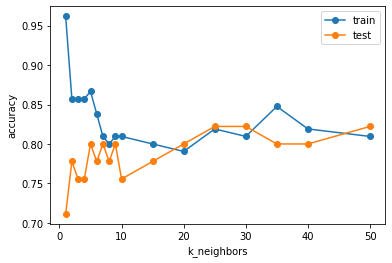

In [34]:
plt.plot(k_vecinos, lista_accuracy_train, 'o-',label='train' )
plt.plot(k_vecinos, lista_accuracy_test, 'o-',label='test')
plt.legend()
plt.xlabel('k_neighbors')
plt.ylabel('accuracy')

Estamos creando una gráfica para ver el valor k para el que tenemos una alta precisión.

__Para pensar:__ ¿cuál será el mejor hiperparámetro?¿En que región hay sobre-ajuste y en cuál sub-ajuste?

Te dejamos una celda que puedes correr para observar distintas fronteras de decisión obtenidas para distintos valores del número de vecinos. ¿Notas para qué número de vecinos y en qué región está sobreajustando? __En K=1, región azul__

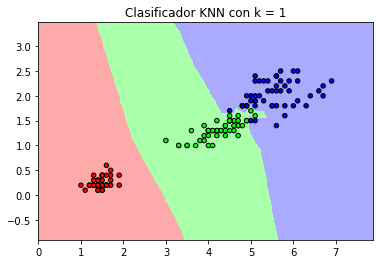

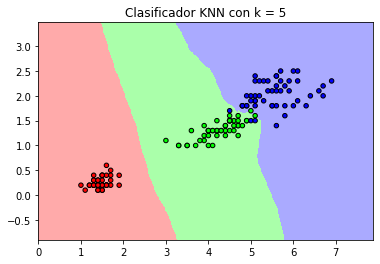

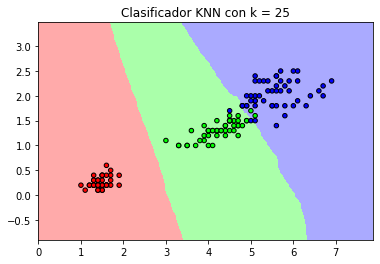

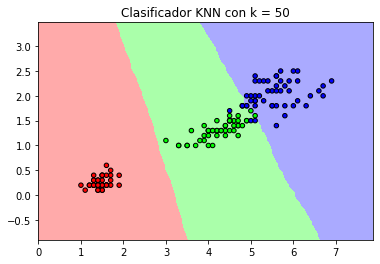

In [35]:
from matplotlib.colors import ListedColormap

X = data[['petal length (cm)', 'petal width (cm)']].values

y = data.target
h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for k in [1,5,25,50]:
    
    # we create an instance of Neighbours Classifier and fit the data.
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Clasificador KNN con k = %i"% (k))

__Curvas de validacíon en Scikit-Learn__

Mencionamos que puedes hacer curvas de validación en Scikit-Learn; pero utilizan algo que todavía no vimos, __Validación Cruzada__. Sin embargo, puedes mirar la documentación para ir familiarizándote.

__Ejercicio:__ Repite entrenamiento, evaluación, optimización de hiperparámetro (profundidad) y visualización de fronteras para unDecisionTreeClassifier.

In [36]:
X = data[["sepal width (cm)", "sepal length (cm)"]]
y = data[["target"]]

In [37]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3, random_state = 0)
X_train.shape, y_train.shape
X_test.shape, y_test.shape

((45, 2), (45, 1))

In [38]:
from sklearn.tree import DecisionTreeClassifier

# Creamos un objeto arbol
tree = DecisionTreeClassifier(max_depth=3, random_state = 42)

In [39]:
tree.fit(X_train, np.ravel(y_train))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [40]:
y_train_pred = clf_knn.predict(X_train)

In [41]:
y_test_pred = clf_knn.predict(X_test)

In [42]:
accuracy_score(y_train,y_train_pred)

0.8380952380952381

In [43]:
accuracy_score(y_test, y_test_pred)

0.8666666666666667

In [44]:
# Definimos las listas vacias para los valores de accuracy deseados
lista_accuracy_train = []
lista_accuracy_test = []

# Definimos la lista de valores de max_depth que vamos a explorar
max_depths = [1,2,3,4,5,6,7,8,9,10]

# Generamos un loop sobre los distintos valores de profundidad 
for i in max_depths:
    tree_2 = DecisionTreeClassifier(max_depth=i, random_state = 42)

# Entrenamos el modelo
    tree_2.fit(X_train, np.ravel(y_train))

# Predecimos y evaluamos sobre el set de entrenamiento
    y_train_pred = tree_2.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    
# Predecimos y evaluamos sobre el set de evaluación
    y_test_pred = tree_2.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    
# Agregamos la información a las listas
    lista_accuracy_train.append(train_acc)
    lista_accuracy_test.append(test_acc)

Text(0, 0.5, 'accuracy')

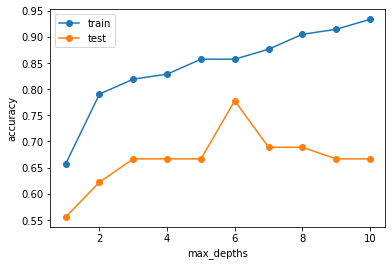

In [45]:
plt.plot(max_depths, lista_accuracy_train, 'o-',label='train' )
plt.plot(max_depths, lista_accuracy_test, 'o-',label='test')
plt.legend()
plt.xlabel('max_depths')
plt.ylabel('accuracy')

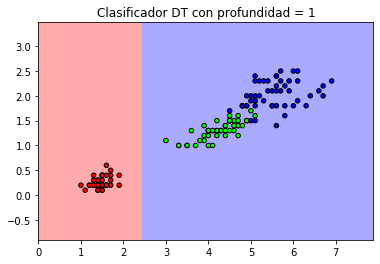

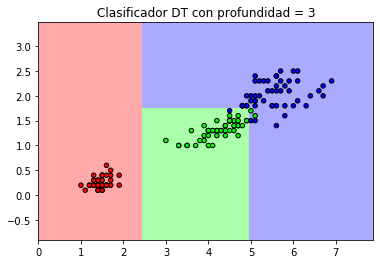

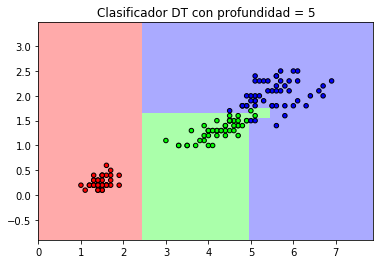

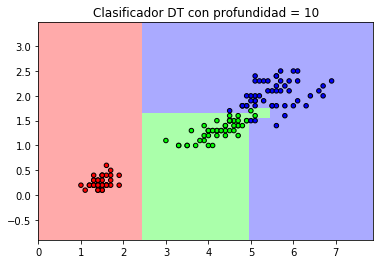

In [46]:
X = data[['petal length (cm)', 'petal width (cm)']].values
y = data.target
h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for max_depth in [1,3,5,10]:
    
    # we create an instance of Neighbours Classifier and fit the data.
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Clasificador DT con profundidad = %i"% (max_depth))

__Validación Cruzada__

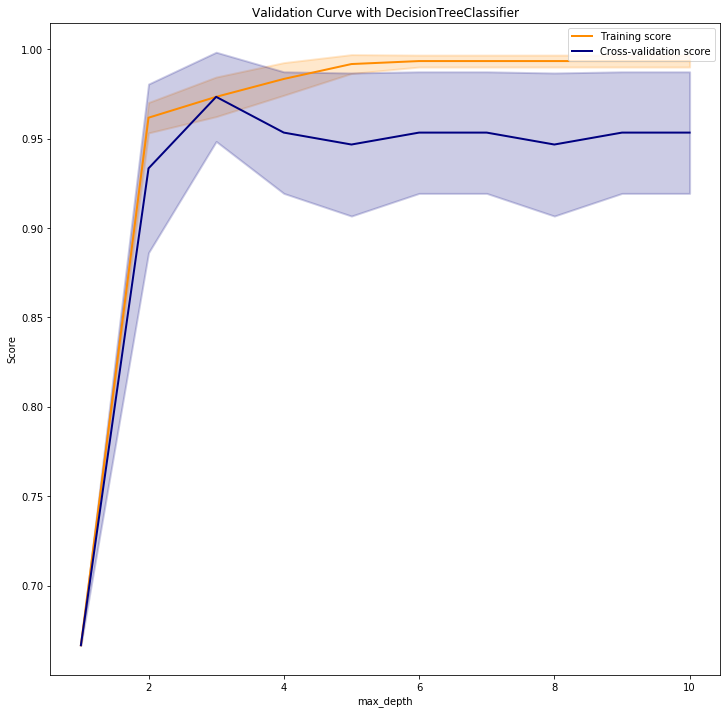

In [47]:
from sklearn.model_selection import validation_curve

param_range = [1,2,3,4,5,6,7,8,9,10]

train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(), X, y, param_name="max_depth", param_range=param_range,
    scoring="accuracy", n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(12,12));
plt.title("Validation Curve with DecisionTreeClassifier")
plt.xlabel("max_depth")
plt.ylabel("Score")
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

__Entrenamiento --> Validación (Donde se Ajustan los Hiperparámetros) --> Testing (Prueba Final)__

__Precisión (Muestra) VS Exaustividad (Población) -->> Se contraponen --> Hay que buscar un equilibrio__